In [1]:
import jax
import jax.numpy as jnp
import optax


import matplotlib.pyplot as plt
import numpy as np


from tqdm import tqdm as tqdm
import pandas as pd


import time

In [2]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):


    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))


    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    
    return samples

In [3]:
def potential_grad(sample, mu, cov):


    eps = 1e-2
    precision = jnp.linalg.inv(cov + eps * jnp.eye(len(mu)))


    return (sample - mu) @ precision

In [4]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=100, seed=0):

    
    key = jax.random.PRNGKey(seed)
    evolved_samples = samples


    for i in range(n_evolution):
        key, subkey = jax.random.split(key)
        grad = potential_grad(evolved_samples, mu, cov)
        noise = jax.random.normal(subkey, shape=evolved_samples.shape)
        evolved_samples = evolved_samples - eps * grad + jnp.sqrt(2 * eps) * noise
        

    return evolved_samples

In [5]:
def sample_unit_directions(key, d, n_proj):


    rand = jax.random.normal(key, shape=(n_proj, d))


    return rand / jnp.linalg.norm(rand, axis=1, keepdims=True)


def sliced_wasserstein_distance(samples1, samples2, n_proj=100, p=2, key=jax.random.PRNGKey(0)):


    d = samples1.shape[1]
    directions = sample_unit_directions(key, d, n_proj)
    

    def proj_sort(s1, s2, dir):


        proj1 = jnp.sort(samples1 @ dir)
        proj2 = jnp.sort(samples2 @ dir)


        return jnp.mean(jnp.abs(proj1 - proj2) ** p)


    wasserstein_per_dir = jax.vmap(lambda dir: proj_sort(samples1, samples2, dir))(directions)

    
    return (jnp.mean(wasserstein_per_dir))**(1/p)

In [6]:
def lm_loss(samples, mu, cov):


    evolved_samples = evolve_langevin(samples, mu, cov)


    return sliced_wasserstein_distance(samples, evolved_samples)

In [7]:
def lm_optimize_with_tracking(
    samples,
    true_mu,
    true_cov,
    n_epochs=1000,
    base_lr=1e-2,
    seed=10,
    eps=1e-2,
    plot_every=2,
    use_lr_schedule=True
):
    

    n, d = samples.shape


    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)


    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))


    params = {
        "mu": mu,
        "A": A
    }


    if use_lr_schedule:
        lr_schedule = optax.linear_schedule(
            init_value=1e-2,
            end_value=base_lr,
            transition_steps=500
        )
        optimizer = optax.adam(learning_rate=lr_schedule)
    else:
        optimizer = optax.adam(learning_rate=base_lr)


    opt_state = optimizer.init(params)


    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)


    history = {
        "loss": [],
        "mu_l2": [],
        "cov_fro": [],
    }


    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)


        mu_val = params["mu"]
        A_val = params["A"]
        cov_val = A_val.T @ A_val


        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_val))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_val, ord='fro'))


        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")


    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]


    return final_mu, final_cov, history

In [8]:
mu = jnp.array([0.0, 1.0, -1.0, 0.5, -0.5, 1.5, -1.5, 0.2, -0.2, 0.8])


cov = jnp.array([
    [1.0, 0.4, 0.3, 0.2, 0.1, 0.0, -0.1, -0.2, -0.3, -0.4],
    [0.4, 1.0, 0.5, 0.3, 0.2, 0.1,  0.0, -0.1, -0.2, -0.3],
    [0.3, 0.5, 1.0, 0.4, 0.3, 0.2,  0.1,  0.0, -0.1, -0.2],
    [0.2, 0.3, 0.4, 1.0, 0.5, 0.3,  0.2,  0.1,  0.0, -0.1],
    [0.1, 0.2, 0.3, 0.5, 1.0, 0.4,  0.3,  0.2,  0.1,  0.0],
    [0.0, 0.1, 0.2, 0.3, 0.4, 1.0,  0.5,  0.3,  0.2,  0.1],
    [-0.1, 0.0, 0.1, 0.2, 0.3, 0.5,  1.0,  0.4,  0.3,  0.2],
    [-0.2,-0.1, 0.0, 0.1, 0.2, 0.3,  0.4,  1.0,  0.5,  0.3],
    [-0.3,-0.2,-0.1, 0.0, 0.1, 0.2,  0.3,  0.5,  1.0,  0.4],
    [-0.4,-0.3,-0.2,-0.1, 0.0, 0.1,  0.2,  0.3,  0.4,  1.0]
])

In [9]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)


time_start = time.time()


final_mu, final_cov, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=800, base_lr=0.1, seed = 0)


time_end = time.time()
time_elapsed = time_end - time_start
time_round = time_elapsed/800
print(time_round)

epoch 0 | loss = 0.812058
epoch 2 | loss = 0.744804
epoch 4 | loss = 0.681584
epoch 6 | loss = 0.624026
epoch 8 | loss = 0.573529
epoch 10 | loss = 0.531179
epoch 12 | loss = 0.497564
epoch 14 | loss = 0.472595
epoch 16 | loss = 0.455340
epoch 18 | loss = 0.444049
epoch 20 | loss = 0.436590
epoch 22 | loss = 0.431123
epoch 24 | loss = 0.426370
epoch 26 | loss = 0.421354
epoch 28 | loss = 0.415319
epoch 30 | loss = 0.407940
epoch 32 | loss = 0.399495
epoch 34 | loss = 0.390662
epoch 36 | loss = 0.382067
epoch 38 | loss = 0.373988
epoch 40 | loss = 0.366395
epoch 42 | loss = 0.359177
epoch 44 | loss = 0.352075
epoch 46 | loss = 0.344568
epoch 48 | loss = 0.335985
epoch 50 | loss = 0.325994
epoch 52 | loss = 0.315021
epoch 54 | loss = 0.304165
epoch 56 | loss = 0.294686
epoch 58 | loss = 0.287280
epoch 60 | loss = 0.281380
epoch 62 | loss = 0.275931
epoch 64 | loss = 0.270527
epoch 66 | loss = 0.265226
epoch 68 | loss = 0.260277
epoch 70 | loss = 0.255828
epoch 72 | loss = 0.251787
epoch 

In [10]:
jnp.set_printoptions(precision=4, suppress=True)


print(jnp.round(mu, 4), "\n\n", jnp.round(final_mu, 4), jnp.linalg.norm(mu - final_mu)/jnp.linalg.norm(mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(final_cov, 4), jnp.linalg.norm(cov - final_cov)/jnp.linalg.norm(cov), "\n\n\n")

[ 0.   1.  -1.   0.5 -0.5  1.5 -1.5  0.2 -0.2  0.8] 

 [ 0.0073  1.034  -0.9609  0.4405 -0.5245  1.4678 -1.5438  0.1919 -0.1538
  0.8127] 0.039744318 



[[ 1.   0.4  0.3  0.2  0.1  0.  -0.1 -0.2 -0.3 -0.4]
 [ 0.4  1.   0.5  0.3  0.2  0.1  0.  -0.1 -0.2 -0.3]
 [ 0.3  0.5  1.   0.4  0.3  0.2  0.1  0.  -0.1 -0.2]
 [ 0.2  0.3  0.4  1.   0.5  0.3  0.2  0.1  0.  -0.1]
 [ 0.1  0.2  0.3  0.5  1.   0.4  0.3  0.2  0.1  0. ]
 [ 0.   0.1  0.2  0.3  0.4  1.   0.5  0.3  0.2  0.1]
 [-0.1  0.   0.1  0.2  0.3  0.5  1.   0.4  0.3  0.2]
 [-0.2 -0.1  0.   0.1  0.2  0.3  0.4  1.   0.5  0.3]
 [-0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.5  1.   0.4]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  1. ]] 

 [[ 0.9954  0.3928  0.2646  0.1824  0.087   0.0648 -0.117  -0.1826 -0.273
  -0.3786]
 [ 0.3928  0.9481  0.4847  0.2604  0.2408  0.0967  0.0078 -0.0693 -0.1553
  -0.2033]
 [ 0.2646  0.4847  1.041   0.4309  0.369   0.2005  0.0937  0.0036 -0.0913
  -0.1953]
 [ 0.1824  0.2604  0.4309  1.0427  0.498   0.2291  0.1438 

In [11]:
history_np = {k: np.array(v) for k, v in history.items()}

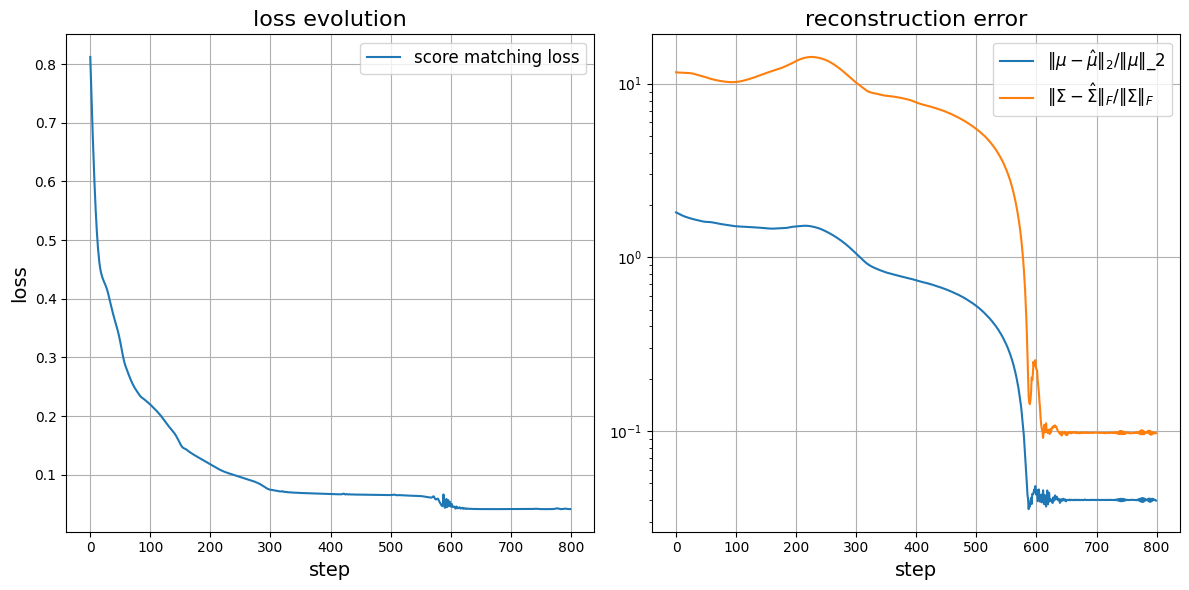

In [12]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="score matching loss")
plt.xlabel("step", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.title("loss evolution", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"]/np.linalg.norm(mu), label=r"$\| \mu - \hat{\mu} \|_2/\|\mu\|\_2$")
plt.plot(history_np["cov_fro"]/np.linalg.norm(cov), label=r"$\| \Sigma - \hat{\Sigma} \|_F/\|\Sigma\|_F$")
plt.yscale("log")
plt.xlabel("step", fontsize=14)
plt.title("reconstruction error", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.tight_layout()
plt.show()

In [ ]:
sample_sizes = np.arange(50, 2001, 50)
n_steps = 800


all_losses = []
all_mu_errors = []
all_cov_errors = []


for n in tqdm(sample_sizes):
    samples = generate_gaussian_samples(mu, cov, n, seed=0)
    _, _, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=n_steps, base_lr=0.1, seed = 0)
    all_losses.append(np.array(history["loss"]))
    all_mu_errors.append(np.array(history["mu_l2"]))
    all_cov_errors.append(np.array(history["cov_fro"]))

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0 | loss = 0.844576
epoch 2 | loss = 0.777862
epoch 4 | loss = 0.715173
epoch 6 | loss = 0.658166


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 176, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


epoch 8 | loss = 0.608257
epoch 10 | loss = 0.566673
epoch 12 | loss = 0.534099
epoch 14 | loss = 0.510396
epoch 16 | loss = 0.494422
epoch 18 | loss = 0.484076
epoch 20 | loss = 0.476480
epoch 22 | loss = 0.469583
epoch 24 | loss = 0.461994
epoch 26 | loss = 0.453598
epoch 28 | loss = 0.444667
epoch 30 | loss = 0.435405
epoch 32 | loss = 0.425939
epoch 34 | loss = 0.416610
epoch 36 | loss = 0.408013
epoch 38 | loss = 0.400787
epoch 40 | loss = 0.395188
epoch 42 | loss = 0.390764
epoch 44 | loss = 0.386303
epoch 46 | loss = 0.381328
epoch 48 | loss = 0.376084
epoch 50 | loss = 0.370736
epoch 52 | loss = 0.365623
epoch 54 | loss = 0.360854
epoch 56 | loss = 0.356295
epoch 58 | loss = 0.351761
epoch 60 | loss = 0.347320
epoch 62 | loss = 0.343050
epoch 64 | loss = 0.339115
epoch 66 | loss = 0.335607
epoch 68 | loss = 0.332436
epoch 70 | loss = 0.329544
epoch 72 | loss = 0.326591
epoch 74 | loss = 0.323655
epoch 76 | loss = 0.320822
epoch 78 | loss = 0.318073
epoch 80 | loss = 0.315621
ep

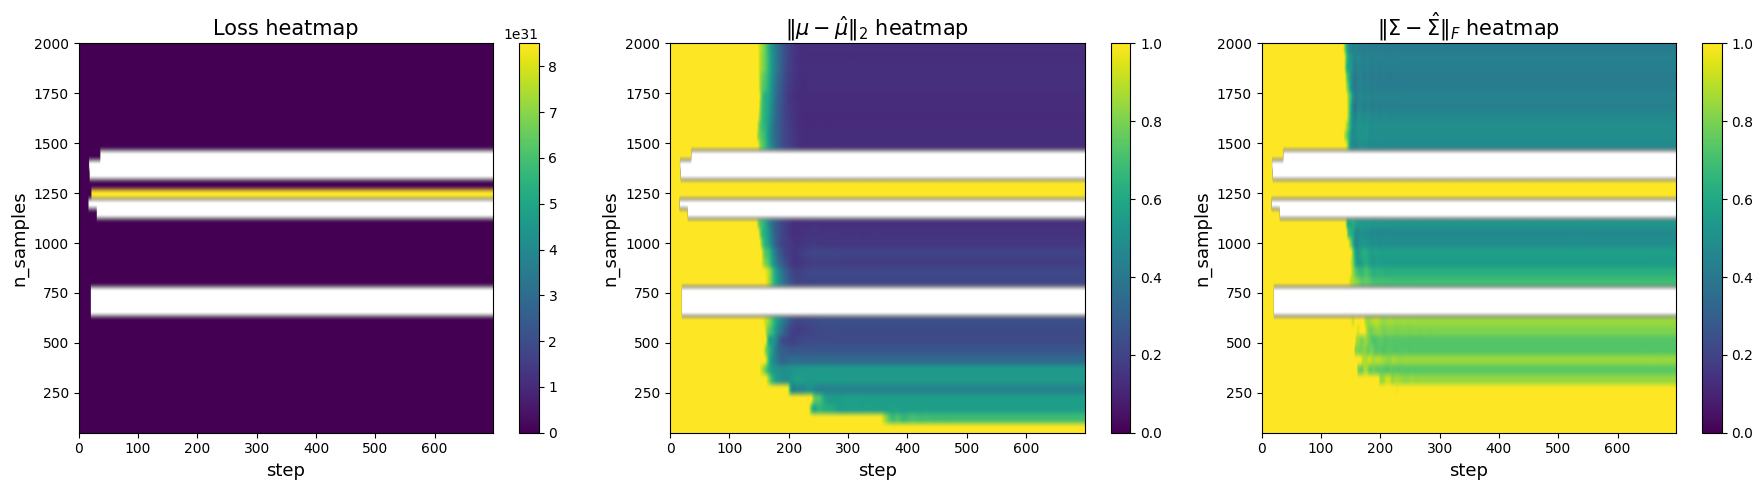

In [ ]:
loss_matrix = np.array(all_losses)
mu_err_matrix = np.array(all_mu_errors)/np.linalg.norm(mu)
cov_err_matrix = np.array(all_cov_errors)/np.linalg.norm(cov)


steps = np.linspace(0, n_steps, n_steps)
sample_sizes = np.arange(50, 2001, 50)


def plot_heatmap(data, title, ylabel, cmap="viridis", vmin=None, vmax=None):
    plt.imshow(data, aspect="auto", origin="lower", cmap=cmap,
               extent=[steps[0], steps[-1], sample_sizes[0], sample_sizes[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel("step", fontsize=13)
    plt.ylabel("n_samples", fontsize=13)
    plt.title(title, fontsize=15)


plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plot_heatmap(loss_matrix, "Loss heatmap", "n_samples")


plt.subplot(1, 3, 2)
plot_heatmap(mu_err_matrix, r"$\|\mu - \hat{\mu}\|_2/\|\mu\|_2$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.subplot(1, 3, 3)
plot_heatmap(cov_err_matrix, r"$\|\Sigma - \hat{\Sigma}\|_F/\|\Sigma\|_F$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.tight_layout()
plt.show()